In [ ]:
#default_exp augmentations

# augmentations

>Implmentation heavily inspired by Ignacio Oguiza - oguiza@gmail.com

In [ ]:
#export
import random
from functools import partial
from scipy.interpolate import CubicSpline
from torchtools.data import *

In [ ]:
#export
import numpy as np
import torch

from fastai2.torch_basics import *
from fastai2.data.all import *

from torchtools.data import *

There are 3 types of noise adding augmentations that can be applied to timeseries data
- scaling: the same noise is a applied to each data point, e.g., each data point is multiplied by a scaling factor f
- jittering: the noise is different for each datapoint, e.g., pick a random scaling factor f_i for each of the data points
- warping: warping is similar to jittering, but the noise is picked from a smooth random curve

These augmentations can be applied to both the y-axis, i.e., the values of the data points, and the x-axis, i.e., the time values of the data points. In case of adding noise to the x-axis of the timeseries data, we usually need to interpolate the corresponding y-value using some kind of piecewise interpolation approach, e.g. CubicSplines

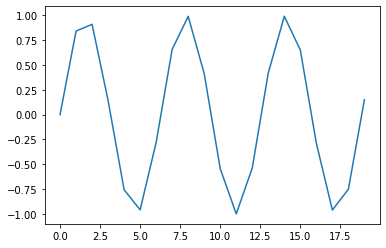

In [ ]:
## set up some sample data
sample_sin = torch.tensor(np.sin(np.arange(20)))[None,:] #one channel
plt.plot(sample_sin[0]);

t = torch.randn((4,20))
ts_tensor = TSTensor(t)

#### Helper Function

In [ ]:
def _get_sin(dims=(1,20)): return torch.tensor([np.sin(x) for x in np.arange(dims[1])]).unsqueeze(0)
def _get_log(dims=(1,20)): return torch.tensor([np.log(x+1) for x in np.arange(dims[1])]).unsqueeze(0)

Cubic Splines are used for smooth, piecewise interpolation of a sequence of datapoints
- piecewise cubic polynomials
- twice continuously differentiable, i.e. smooth

We use cubic splines both to create random curves for sampling noise for warping and interpolating data points in the case of x-axis noise.

In the example below, we add some noise to our sample data and interpolate the data points with a cubic spline. Since we now have a continuous interpolation of the original data, we can add noise to the x-axis, the interval [0:19] and use the corresponding interpolation values.

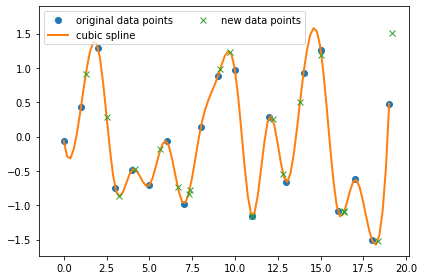

In [ ]:
#hide
rand_noise = torch.randn(sample_sin.shape)
sample_sin = sample_sin+rand_noise
plt.plot(sample_sin[0], 'o', linewidth=1, label='original data points');
cspline = CubicSpline(np.arange(20), sample_sin[0])
plt.plot(np.linspace(0,19, num=100), cspline(np.linspace(0,19, num=100)), linewidth=2, label='cubic spline');
xs_noise = np.arange(20)+np.random.normal(0,0.4, size=20)
plt.plot(xs_noise, cspline(xs_noise), 'x', label='new data points')
plt.legend(loc='upper left', ncol=2)
plt.tight_layout()
plt.show();

In [ ]:
#exports
#oguiza implementation, only used for _magwarp
# def random_curve_generator(ts, magnitude=.1, order=4, noise=None):
#     '''
#     sample points from a gaussian with mean 1 and create a smooth cubic "random curve" from these points
#     '''
#     seq_len = ts.shape[-1]
#     x = np.linspace(-seq_len, 2 * seq_len - 1, 3 * (order - 1) + 1, dtype=int)
#     x2 = np.random.normal(loc=1.0, scale=magnitude, size=len(x))
#     f = CubicSpline(x, x2, axis=-1)
#     return f(np.arange(seq_len))

In [ ]:
#exports
def _create_random_curve(n_channels, seq_len, magnitude, order):
    '''
    create a random curve for each channel in the interval[0, seq_len-1] on order random points
    '''
    x = np.linspace(0, seq_len-1, order)
    y = np.random.normal(loc=1.0, scale=magnitude, size=(n_channels, len(x)))
    f = CubicSpline(x, y, axis=-1)
    return f

def noise_from_random_curve(dim, magnitude=.1, order=4):
    '''
    sample points from a gaussian with mean 1 and create a smooth cubic "random curve" from these points
    ts, needs to be 2D
    order: number of sample to create the random curve from
    '''
    n_channels, seq_len = dim
    f = _create_random_curve(n_channels, seq_len, magnitude, order)
    return torch.tensor(f(np.arange(seq_len)))

def noise_from_normal(dim, magnitude=.1):
    '''
    sample random noise from a gaussian with mean=1.0 and std=magnitude
    '''
    n_channels, seq_len = dim
    return torch.tensor(np.random.normal(loc=1.0, scale=magnitude, size=(n_channels, seq_len)))

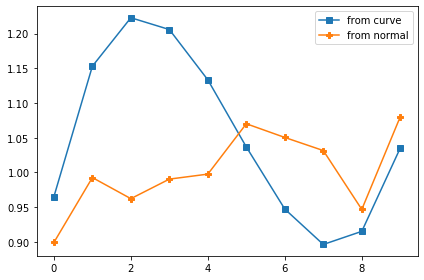

In [ ]:
t = (1,10)
plt.plot(noise_from_random_curve(t).T, marker='s', label='from curve')
plt.plot(noise_from_normal(t).T, marker='P', label='from normal')
plt.legend()
plt.tight_layout();

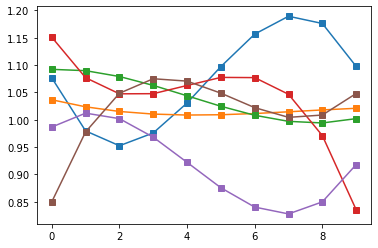

In [ ]:
plt.plot(noise_from_random_curve((6,10)).T, marker='s');

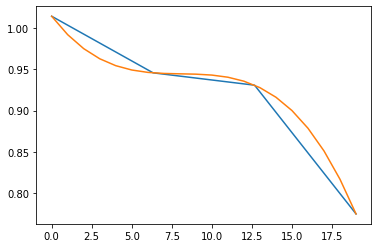

In [ ]:
samples = np.random.normal(loc=1.0, scale=0.1, size=4)
plt.plot(np.linspace(0,19,4), samples);
rcurve = CubicSpline(np.linspace(0,19,4), samples)
# plt.plot(np.linspace(0,19,100), rcurve(samples));

plt.plot(rcurve(np.arange(20)));

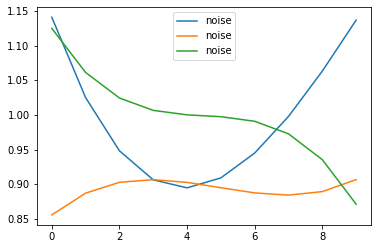

In [ ]:
#multiple channels
plt.plot(noise_from_random_curve((3,10)).T, label='noise')
plt.legend();

In [ ]:
n_channels = 3; seq_len=20; magnitude=0.2
noise = torch.normal(0, magnitude, (n_channels, seq_len))
noise.shape, noise_from_normal((n_channels, seq_len)).shape

(torch.Size([3, 20]), torch.Size([3, 20]))

#### Y Noise

In [ ]:
#export
def _ynoise(x, magnitude=.1, add=True, smooth=True, **kwargs):
    '''
    add random noise to timeseries values
    '''
#     assert isinstance(x, Tensor)
    assert len(x.shape)==2 or len(x.shape)==3, 'tensor needs to be 2D or 3D'
    if magnitude <= 0: return x
    n_channels, seq_len = x.shape[-2], x.shape[-1]
    noise_fn = noise_from_random_curve if smooth else noise_from_normal
    
    noise = noise_fn((n_channels, seq_len), magnitude=magnitude, **kwargs).to(x.device)
    if add:
        output = x + (noise-1)
        return output.to(x.device, x.dtype)
    else:
        output = x * (noise)
        return output.to(x.device, x.dtype) 

In [ ]:
#export
_ynoise_warp = partial(_ynoise, smooth=True)
_ynoise_normal = partial(_ynoise, smooth=False)
_ynoise_normal_mul = partial(_ynoise, smooth=False, add=False)

In [ ]:
_test_aug_func(_ynoise_normal_mul)

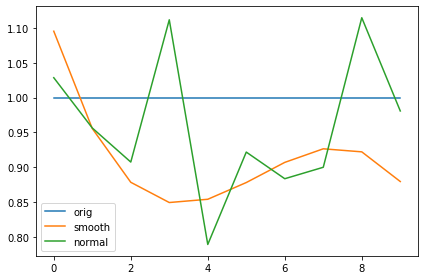

In [ ]:
t = torch.ones(1,10)
plt.plot(t.T, label='orig')
plt.plot(_ynoise_warp(t).T, label='smooth')
plt.plot(_ynoise_normal(t).T, label='normal')
plt.legend()
plt.tight_layout();

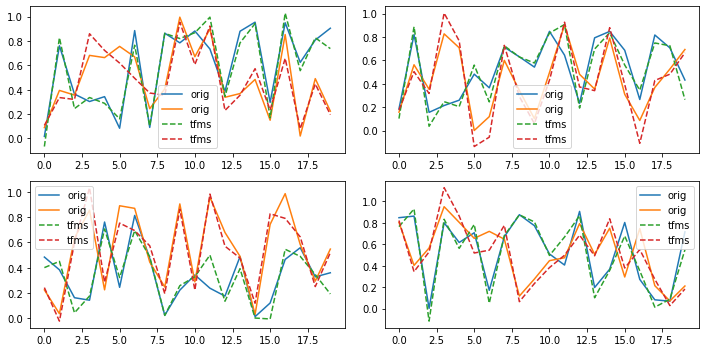

In [ ]:
## batch transform
t = torch.rand(4,2,20)
t_tfmd = _ynoise_normal(t)
_, axes = plt.subplots(2,2, figsize=(10,5))
for i,ax in enumerate(axes.flatten()):
    ax.plot(t[i].T, label='orig')
    ax.plot(t_tfmd[i].T, linestyle='dashed', label = 'tfms')
    ax.legend()
plt.tight_layout()

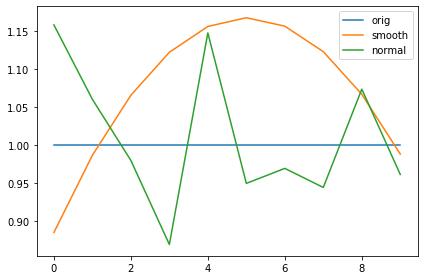

In [ ]:
t = torch.ones(1,10)
plt.plot(t.T, label='orig')
plt.plot(_ynoise_warp(t, add=False).T, label='smooth')
plt.plot(_ynoise_normal(t, add=False).T, label='normal')
plt.legend()
plt.tight_layout();

In [ ]:
#export
# smooth does not make sense probably unless there is some channel dependence and ordering
def _yscale(x, magnitude=.1, normal=False, by_channel=False):
    if magnitude <= 0: return x
    if normal: 
        scale = 1.+2*(torch.randn(1 if not by_channel else x.shape[-2])-0.5)*magnitude
    else:
#         scale = 1 + torch.rand(1) * magnitude  # uniform [0:1], normal possible
        scale = 1.+2*(torch.rand(1 if not by_channel else x.shape[-2])-0.5)*magnitude
#         if np.random.rand() < .5: scale = 1 / scale # scale down
#     output = x * scale.to(x.device)
    return x*scale.to(x.device) if not by_channel else x*scale[..., None].to(x.device)

In [ ]:
def _test_aug_func(fn):
    '''
    sanity checks for augmentation functions
    '''
    t1 = torch.randn(10,100)
    t2 = torch.randn(128,10,100)
    assert fn(t1).shape == t1.shape
    assert fn(t2).shape == t2.shape
    assert fn(t1.cuda()).shape == t1.shape
    assert fn(t2.cuda()).shape == t2.shape    
    assert fn(t2.cuda()).device == t2.cuda().device

In [ ]:
_test_aug_func(partial(_yscale, by_channel=False))
_test_aug_func(partial(_yscale, by_channel=True))
_test_aug_func(partial(_yscale, normal=True, by_channel=True))

In [ ]:
t1 = torch.ones((2,4,2))
_yscale(t1, by_channel=True)

tensor([[[1.0838, 1.0838],
         [1.0903, 1.0903],
         [0.9716, 0.9716],
         [0.9915, 0.9915]],

        [[1.0838, 1.0838],
         [1.0903, 1.0903],
         [0.9716, 0.9716],
         [0.9915, 0.9915]]])

tensor([0, 1, 2, 3, 4]) tensor([0.0000, 0.9600, 1.9200, 2.8800, 3.8401]) tensor([0.0000, 1.0821, 2.1643, 3.2464, 4.3286])


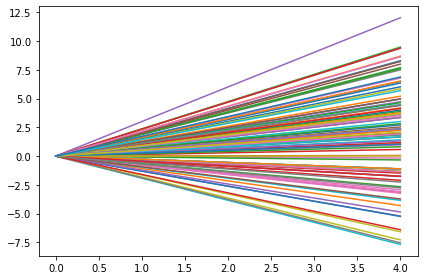

In [ ]:
t = torch.arange(5)
print(t,_yscale(t), _yscale(t, normal=True))
plt.plot(t, t.T, label='original')
for _ in range(100):
    plt.plot(t, _yscale(t, magnitude=0.5, normal=True).T, label='uniform')
# plt.plot(t, _yscale(t, magnitude=0.5, normal=True).T, label='normal')
# # plt.plot(_ynoise_normal(t, add=False).T, label='normal')
# plt.legend()
plt.tight_layout();

In [ ]:
_yscale(t, magnitude=0.4)

tensor([0.0000, 0.9794, 1.9587, 2.9381, 3.9174])

### Distorting the X-axis (Time)

#### Time Warping

In [ ]:
#x-axis noise, cumulative, oguiza
# def random_intervals_from_curve(ts, magnitude=.1, order=4, noise=None):
#     '''noise to `[0,..., seq_len]` by sampling deltas from a random curve'''
#     noise_cum = noise_from_random_curve(ts, magnitude=magnitude, order=order).cumsum(1)
#     noise_cum = noise_cum - np.expand_dims(noise_cum[:,0], -1)
#     noise_cum = noise_cum/np.expand_dims(noise_cum[:,-1], -1) * (ts.shape[1]-1)
# #     x /= x[-1]
# #     x = np.clip(x, 0, 1)
# #     print(x)
# #     return x * (ts.shape[-1] - 1)
#     return noise_cum

In [ ]:
#x-axis noise, cumulative, oguiza
# def random_intervals_from_normal(ts, magnitude=.1, order=4, noise=None):
#     '''noise to `[0,..., seq_len]` by sampling deltas from a random curve'''
#     noise_cum = noise_from_normal(ts, magnitude=magnitude).cumsum(1)
#     noise_cum = noise_cum - np.expand_dims(noise_cum[:,0], -1)
#     noise_cum = noise_cum/np.expand_dims(noise_cum[:,-1], -1) * (ts.shape[1]-1)
# #     x /= x[-1]
# #     x = np.clip(x, 0, 1)
# #     print(x)
# #     return x * (ts.shape[-1] - 1)
#     return noise_cum

In [ ]:
#export
def _normalize_timesteps(timesteps):
    '''
    distorted timesteps in [0,..,seq_len]
    '''
#     timesteps = timesteps - np.expand_dims(timesteps[:,0], -1)
#     timesteps = timesteps.clone()
    timesteps = timesteps.sub(timesteps[:,0].unsqueeze(-1))

#     timesteps = timesteps/np.expand_dims(timesteps[:,-1], -1) * (timesteps.shape[1]-1)
    timesteps=timesteps.div(timesteps[:,-1].unsqueeze(-1)) * (timesteps.shape[1]-1)
    
    return timesteps
    

def distort_time(dim, magnitude=.1, smooth=False, **kwargs):
    '''
    distort the time steps (x-axis) of timeseries
    '''
    n_channels, seq_len = dim
    noise_fn = noise_from_random_curve if smooth else noise_from_normal
    noise = noise_fn((n_channels, seq_len), magnitude=magnitude, **kwargs)
    time_new = _normalize_timesteps(noise.cumsum(1))
#     noise_cum = noise_cum - np.expand_dims(noise_cum[:,0], -1)
#     noise_cum = noise_cum/np.expand_dims(noise_cum[:,-1], -1) * (ts.shape[1]-1)
#     x /= x[-1]
#     x = np.clip(x, 0, 1)
#     print(x)
#     return x * (ts.shape[-1] - 1)
    return time_new

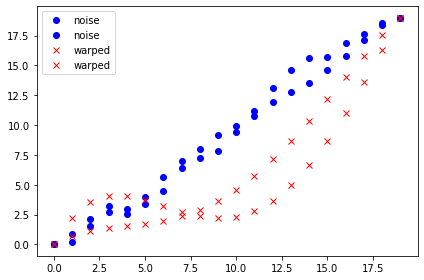

In [ ]:
t=(2,20)
plt.plot(distort_time(t, 0.5).T, 'bo', label='noise')
plt.plot(distort_time(t, 0.5, smooth=True).T, 'rx', label='warped')
plt.legend()
plt.tight_layout();


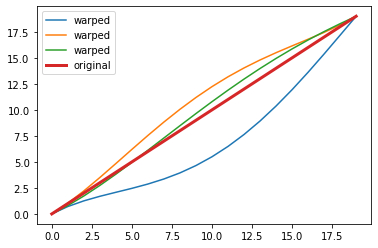

In [ ]:
plt.plot(distort_time((3,20), magnitude=0.3, smooth=True).T, label='warped')
plt.plot(np.arange(20), label='original', linewidth=3)
plt.legend();

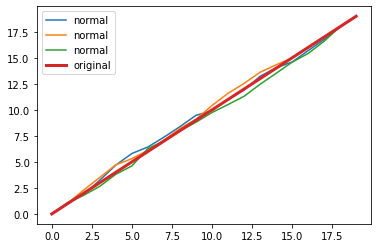

In [ ]:
plt.plot(distort_time((3,20), magnitude=0.3).T, label='normal')
plt.plot(np.arange(20), label='original', linewidth=3)
plt.legend();

In [ ]:
#export
def _timenoise(x, magnitude=.1, smooth=False, **kwargs):
    '''This is a slow batch tfm on cpu'''
    if magnitude <= 0: return x
#     if len(x.shape)==1: x=x.unsqueeze(0) #no support for 1D tensors
    assert len(x.shape)==2 or len(x.shape)==3, 'tensor needs to be 2D or 3D'
    n_channels, seq_len = x.shape[-2], x.shape[-1]
    x_device = x.device ## make sure to put outpout on right device
    x=x.cpu() ## only works on cpu
    
#    return f
#     plt.plot(x.T)
#     plt.plot(np.linspace(0,10), f(np.linspace(0,10)[:, None]).squeeze())
    new_x = distort_time((n_channels,seq_len), magnitude=magnitude, smooth=True, **kwargs).to(x.device)
    fs = [CubicSpline(np.arange(seq_len), x[...,i,:], axis=-1) for i in range(n_channels)]
#     new_y = f(new_x, )
#     print(fs(new_x).shape)
#     return new_x
    new_y = torch.stack([torch.tensor(fs[i](xi)) for i,xi in enumerate(new_x)])
    if len(x.shape)==3: new_y = new_y.permute(1,0,2)
    
    return new_y.to(x_device, x.dtype)

In [ ]:
#export
def _timewarp(x, magnitude=.1, order=4):
    return _timenoise(x, magnitude, smooth=True, order=order)
def _timenormal(x, magnitude=.1):
    return _timenoise(x, magnitude, smooth=False)

#### Zoom

In [ ]:
#export
def _randomize(p):
    p = np.random.beta(p,p)
    return np.maximum(p, 1-p)

In [ ]:
#export
def _rand_steps(n, p, rand=False, window=False):
    if rand: p = _randomize(p)
    n_steps = int(p*n)        
    if window:
        start = np.random.randint(0, n-n_steps+1)
        return np.arange(start, start+n_steps)
    else: return np.sort(np.random.choice(n, n_steps, replace=False))    

In [ ]:
_rand_steps(10, 0.4, window=True, rand=True)

array([0, 1, 2, 3, 4])

In [ ]:
##only for reference
def _timenoise(x, magnitude=.1, smooth=False, **kwargs):
    '''This is a slow batch tfm on cpu'''
    if magnitude <= 0: return x
#     if len(x.shape)==1: x=x.unsqueeze(0) #no support for 1D tensors
    assert len(x.shape)==2 or len(x.shape)==3, 'tensor needs to be 2D or 3D'
    n_channels, seq_len = x.shape[-2], x.shape[-1]
    x_device = x.device ## make sure to put outpout on right device
    x=x.cpu() ## only works on cpu
    
#    return f
#     plt.plot(x.T)
#     plt.plot(np.linspace(0,10), f(np.linspace(0,10)[:, None]).squeeze())
    new_x = distort_time((n_channels,seq_len), magnitude=magnitude, smooth=True, **kwargs).to(x.device)
    fs = [CubicSpline(np.arange(seq_len), x[...,i,:], axis=-1) for i in range(n_channels)]
#     new_y = f(new_x, )
#     print(fs(new_x).shape)
#     return new_x
    new_y = torch.stack([torch.tensor(fs[i](xi)) for i,xi in enumerate(new_x)])
    if len(x.shape)==3: new_y = new_y.permute(1,0,2)
    
    return new_y.to(x_device, x.dtype)

In [ ]:
#export
def _zoom(x, magnitude=.2, rand=False, zoomout=False, window=True, verbose=False):
    '''This is a slow batch tfm
    win_len: zoom into original ts into a section consisting of win_len original data points
    randomly choose one of the seq_len-win_len possible starting points for that section
    within that section, consider seq_len(number of original datapoints) evenly distributed new datapoints 
    and interpolate the respective values with a cubic spline 
    '''
    if magnitude == 0: return x
    x_device = x.device ## make sure to put outpout on right device
    x=x.cpu() ## only on cpu with CubicSpline

    n_channels, seq_len = x.shape[-2], x.shape[-1]
    assert len(x.shape)==2 or len(x.shape)==3, 'tensor needs to be 2D or 3D'
    
    window=_rand_steps(seq_len, 1-magnitude, rand=rand, window=window)
    if zoomout: window=np.arange(seq_len-len(window), seq_len)
    pv(window, verbose)
#     x2 = x[..., window]
    fs = [CubicSpline(np.arange(len(window)), x[...,i, window], axis=-1) for i in range(n_channels)]
    output = torch.stack(
        [torch.tensor(fs[i](np.linspace(0,len(window)-1, num=seq_len))) for i in range(n_channels)])
    if len(x.shape)==3: output = output.permute(1,0,2)
#     output = x.new(f(np.linspace(0, len(window) - 1, num=seq_len)))
    
#     new_y = torch.stack([torch.tensor(fs[i](xi)) for i,xi in enumerate(new_x)])
#     if len(x.shape)==3: new_y = new_y.permute(1,0,2)
    
#     return new_y.to(x_device, x.dtype)
    
    
    return output.to(x_device, x.dtype)


In [ ]:
tb = torch.rand(16,3,8)
_zoom(tb).shape

torch.Size([16, 3, 8])

''

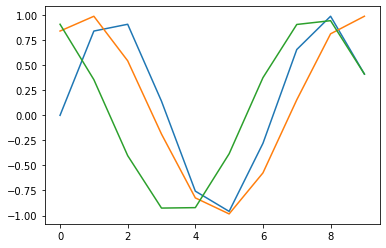

In [ ]:
t=_get_sin((1,10))
plt.plot(t[0])
plt.plot(_zoom(t, zoomout=False)[0])
plt.plot(_zoom(t, zoomout=True)[0])
;

In [ ]:
_zoom(ts_tensor.to('cuda'), zoomout=False)

tensor([[ 1.0530, -1.3702,  0.1221, -0.0355, -1.4002, -0.3418,  0.1822, -0.4737,
          0.8327,  3.0920,  1.1811, -1.0207, -1.8580, -1.4053, -0.2661,  0.5927,
          0.6584,  0.0788, -0.6324, -0.8586],
        [ 0.7895,  0.6760, -0.3492, -0.2252,  0.6655,  0.5241,  0.2768,  1.1780,
          0.7255, -0.7142,  0.6774,  0.6777,  0.1052, -0.2533, -0.5892,  0.0939,
          1.5900,  1.4671, -0.0271,  0.7108],
        [-0.4289, -0.5799, -0.0298,  0.3650,  0.3583,  0.1966, -0.0483,  0.3251,
          0.1623, -0.9320, -1.0975, -0.1436, -0.3411, -0.8086, -0.3031, -0.6704,
         -0.5409, -0.0286, -0.1920, -2.0214],
        [ 0.9885, -0.1273, -1.6060, -1.2351,  0.3069,  0.0294, -2.0747, -0.5829,
          0.8181, -0.4016,  0.5871,  0.8253, -0.0089, -0.1378,  0.7248,  0.8360,
          1.1247,  0.9406, -0.0744, -1.0656]], device='cuda:0')

''

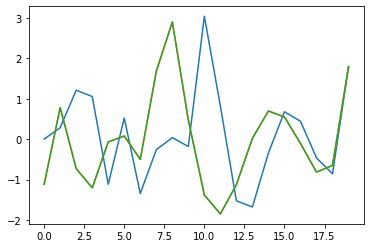

In [ ]:
# ts_tensor=_get_sin((1,10))
plt.plot(ts_tensor[0])
plt.plot(_zoom(ts_tensor.to('cuda'), zoomout=False).cpu()[0])
plt.plot(_zoom(ts_tensor.to('cuda'), zoomout=True).cpu()[0])
# plt.plot(_zoom(t, zoomout=True)[0])
;

In [ ]:
#export
_zoomin = partial(_zoom, rand=True)
_zoomout = partial(_zoom, rand=True, zoomout=True)

def _randzoom(x, magnitude=.2):
    p = np.random.rand()
    return _zoomin(x, magnitude) if p<0.5 else _zoomout(x, magnitude)

In [ ]:
_randzoom(t)[0]

tensor([-0.9589, -0.7526, -0.3859,  0.0535,  0.4779,  0.8009,  0.9714,  0.9732,
         0.7916,  0.4121])

In [ ]:
_randzoom(tb)[0:3]

tensor([[[ 0.8656,  0.2926,  0.2551,  0.5067,  0.8036,  0.9486,  0.7923,
           0.1870],
         [ 0.0132,  0.6428,  0.7703,  0.6994,  0.7227,  0.8796,  0.9565,
           0.7290],
         [ 0.9649,  0.9438,  0.6329,  0.3273,  0.3101,  0.5900,  0.9008,
           0.9648]],

        [[ 0.6170,  0.6972,  0.6897,  0.6020,  0.4445,  0.2883,  0.2651,
           0.5092],
         [ 0.2659,  0.2484,  0.5782,  0.8699,  0.7565,  0.2918, -0.0500,
           0.2241],
         [ 0.0260, -0.1026,  0.2403,  0.6292,  0.6580,  0.3654,  0.2348,
           0.7689]],

        [[ 0.1855,  0.4387,  0.6282,  0.7293,  0.7201,  0.6453,  0.6167,
           0.7489],
         [ 0.1204,  0.1712,  0.4229,  0.6325,  0.5687,  0.2646,  0.0182,
           0.1387],
         [ 0.7659,  0.5064,  0.1336, -0.0547,  0.2202,  0.7977,  1.0777,
           0.4410]]])

#### Random Timesteps

Essentially like zoomin, but non-consecutive timesteps

In [ ]:
#export
_randtimesteps = partial(_zoom, window=False)    

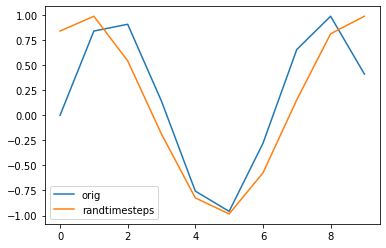

In [ ]:
plt.plot(t[0], label='orig')
plt.plot(_randtimesteps(t)[0], label='randtimesteps')
plt.legend();

#### Erasing Transforms

Again, these transforms sample timesteps (consecutive or non-consecutive). Instead of interpolating into the sampled timesteps, here the the sampled timesteps are replaced with some other value, e.g., zero, or the mean.

In [ ]:
#export
def _complement_steps(n, steps, verbose=False):
    pv('complement', verbose)
    pv(n, verbose)
    pv(steps, verbose)
    return np.sort(np.array(list(set(n)-set(steps))))
    

In [ ]:
#export
def _center_steps(n, steps):
    start = n//2-len(steps)//2
    return np.arange(start, start+len(steps))

In [ ]:
#export
def _create_mask_from_steps(x, steps, dim=False):
    '''create a 2D mask'''
    mask = torch.zeros_like(x, dtype=torch.bool)
#     print(mask.shape)
#     print(steps)
#     print(mask[steps,:])
#     print(mask[:, steps])
    if dim:
        mask[steps, :] = True
    else:
        mask[:, steps] = True
    return mask

In [ ]:
#export
def _erase(x, magnitude=.2, rand=False, window=False, mean=False, complement=False, center=False, mask=False,
          dim=False, verbose=False):
    '''erasing parts of the timeseries'''
    if magnitude==0: return x
    
    pv(f'_erase input shape {x.shape}', verbose)
    assert len(x.shape)==2 or len(x.shape)==3, 'tensor needs to be 2D or 3D'
    is_batch = len(x.shape)==3
    
    pv(x.shape, verbose)
    
    n_channels, seq_len = x.shape[-2], x.shape[-1]
    p = 1-magnitude if complement else magnitude
    n = n_channels if dim else seq_len
    steps = _rand_steps(n, p, rand=rand, window=window)
    
    
    if center: steps = _center_steps(n, steps)
    if complement: steps = _complement_steps(np.arange(n), steps, verbose=verbose)
    pv(f'steps {steps}', verbose)
    output = x.clone()
    if not is_batch: output.unsqueeze_(0)
    value = 0 if not mean else output.mean((0,2), keepdims=True)
    mask = torch.rand_like(output[0])<magnitude if mask else _create_mask_from_steps(output[0], steps, dim=dim)
    
    pv(mask, verbose)
    pv(value, verbose)
    

    if not mean: output[..., mask] = 0
    else:
        assert mask.shape[-2] == value.shape[-2]
        output[..., mask]=0
        output.add_(mask.int().to(x.dtype).unsqueeze(0)*value)
    return output.squeeze_(-2) if not is_batch else output
    

In [ ]:
t2 = torch.rand((3,10))
t3 = torch.rand((16,3,10))

# tb[..., mask].shape

In [ ]:
t3.squeeze(-2).shape

torch.Size([16, 3, 10])

In [ ]:
means = t3.mean((0,-1), keepdims=True)

In [ ]:
means.shape

torch.Size([1, 3, 1])

In [ ]:
t2_erased = _erase(t2, verbose=True, mean=True)

t2_erased

_erase input shape torch.Size([3, 10])
torch.Size([3, 10])
steps [2 9]
tensor([[False, False,  True, False, False, False, False, False, False,  True],
        [False, False,  True, False, False, False, False, False, False,  True],
        [False, False,  True, False, False, False, False, False, False,  True]])
tensor([[[0.5660],
         [0.5400],
         [0.5674]]])


tensor([[[0.9351, 0.2901, 0.5660, 0.3143, 0.9966, 0.1356, 0.8274, 0.0047,
          0.8867, 0.5660],
         [0.7330, 0.2625, 0.5400, 0.8428, 0.2184, 0.0689, 0.9811, 0.0654,
          0.7460, 0.5400],
         [0.5733, 0.5493, 0.5674, 0.9712, 0.7013, 0.8296, 0.4804, 0.8109,
          0.0878, 0.5674]]])

In [ ]:
t3_erased = _erase(t3, verbose=True, mean=False)

t3_erased[:2]

_erase input shape torch.Size([16, 3, 10])
torch.Size([16, 3, 10])
steps [0 8]
tensor([[ True, False, False, False, False, False, False, False,  True, False],
        [ True, False, False, False, False, False, False, False,  True, False],
        [ True, False, False, False, False, False, False, False,  True, False]])
0


tensor([[[0.0000, 0.6490, 0.0693, 0.2001, 0.5926, 0.5474, 0.4976, 0.1015,
          0.0000, 0.1911],
         [0.0000, 0.1556, 0.9806, 0.3579, 0.8694, 0.3682, 0.4347, 0.8510,
          0.0000, 0.5272],
         [0.0000, 0.8884, 0.1759, 0.3019, 0.8024, 0.7163, 0.8830, 0.7962,
          0.0000, 0.7019]],

        [[0.0000, 0.9194, 0.2753, 0.4160, 0.8120, 0.0136, 0.4872, 0.6109,
          0.0000, 0.5301],
         [0.0000, 0.9709, 0.5430, 0.4492, 0.0499, 0.5830, 0.7498, 0.3533,
          0.0000, 0.6368],
         [0.0000, 0.1740, 0.3515, 0.3348, 0.7003, 0.5992, 0.7912, 0.2006,
          0.0000, 0.9970]]])

In [ ]:
#export
_timestepzero = partial(_erase)
_timestepmean = partial(_erase, mean=True)
_cutout = partial(_erase, window=True)
_crop = partial(_erase, window=True, complement=True)
_randomcrop = partial(_erase, window=True, rand=True, complement=True)
_centercrop = partial(_erase, window=True, center=True,complement=True)
_maskout = partial(_erase, mask=True)
_dimout = partial(_erase, dim=True)

In [ ]:
t = torch.rand((16,3,10))

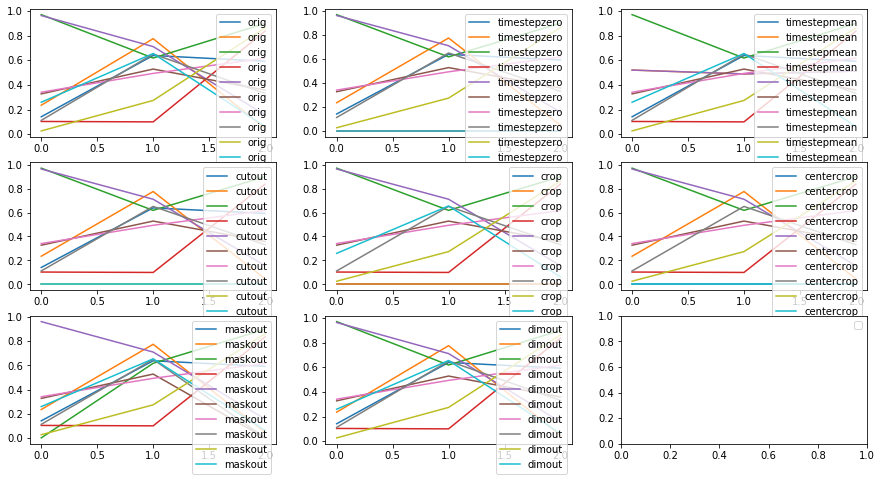

In [ ]:
t.cuda()
_, axes = plt.subplots(3,3, figsize=(15,8))
# for ax in axes.flatten():
axes[0,0].plot(t[0], label='orig')
axes[0,1].plot(_timestepzero(t)[0], label='timestepzero')
axes[0,2].plot(_timestepmean(t)[0], label='timestepmean')
axes[1,0].plot(_cutout(t)[0], label='cutout')
axes[1,1].plot(_crop(t)[0], label='crop')
axes[1,2].plot(_centercrop(t)[0], label='centercrop')
axes[2,0].plot(_maskout(t)[0], label='maskout')
axes[2,1].plot(_dimout(t)[0], label='dimout')
# axes[2,2].plot(_centercrop(t)[0], label='_centercrop')

for ax in axes.flatten():
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)

In [ ]:
t_sin = _get_sin((1,10))

In [ ]:
_timestepzero(t_sin, verbose=True)

_erase input shape torch.Size([1, 10])
torch.Size([1, 10])
steps [2 7]
tensor([[False, False,  True, False, False, False, False,  True, False, False]])
0


tensor([[ 0.0000,  0.8415,  0.0000,  0.1411, -0.7568, -0.9589, -0.2794,  0.0000,
          0.9894,  0.4121]])

In [ ]:
_timestepzero(t.cuda(), verbose=True)

_erase input shape torch.Size([16, 3, 10])
torch.Size([16, 3, 10])
steps [6 8]
tensor([[False, False, False, False, False, False,  True, False,  True, False],
        [False, False, False, False, False, False,  True, False,  True, False],
        [False, False, False, False, False, False,  True, False,  True, False]],
       device='cuda:0')
0


tensor([[[0.1413, 0.2351, 0.9706, 0.1032, 0.9632, 0.3273, 0.0000, 0.1124,
          0.0000, 0.2592],
         [0.6388, 0.7754, 0.6180, 0.0998, 0.7110, 0.5286, 0.0000, 0.6509,
          0.0000, 0.6549],
         [0.5922, 0.0470, 0.8993, 0.8368, 0.1566, 0.3583, 0.0000, 0.3309,
          0.0000, 0.0627]],

        [[0.8994, 0.2093, 0.9272, 0.9836, 0.5528, 0.9696, 0.0000, 0.7835,
          0.0000, 0.2049],
         [0.6484, 0.8777, 0.4917, 0.5651, 0.1361, 0.2540, 0.0000, 0.2332,
          0.0000, 0.9295],
         [0.2651, 0.3393, 0.2189, 0.5335, 0.7595, 0.3735, 0.0000, 0.2624,
          0.0000, 0.1073]],

        [[0.4416, 0.6679, 0.3779, 0.5395, 0.3550, 0.0144, 0.0000, 0.4485,
          0.0000, 0.9646],
         [0.2610, 0.1931, 0.1771, 0.2405, 0.0897, 0.7677, 0.0000, 0.3370,
          0.0000, 0.3998],
         [0.1729, 0.4399, 0.3063, 0.1716, 0.8101, 0.6300, 0.0000, 0.8835,
          0.0000, 0.1144]],

        [[0.7770, 0.6374, 0.8805, 0.6668, 0.8534, 0.7630, 0.0000, 0.3206,
          0

In [ ]:
_timestepmean(t, verbose=True)

_erase input shape torch.Size([16, 3, 10])
torch.Size([16, 3, 10])
steps [0 5]
tensor([[ True, False, False, False, False,  True, False, False, False, False],
        [ True, False, False, False, False,  True, False, False, False, False],
        [ True, False, False, False, False,  True, False, False, False, False]])
tensor([[[0.5205],
         [0.4891],
         [0.5119]]])


tensor([[[5.2054e-01, 2.3512e-01, 9.7055e-01, 1.0321e-01, 9.6315e-01,
          5.2054e-01, 3.4077e-01, 1.1236e-01, 2.6468e-02, 2.5922e-01],
         [4.8912e-01, 7.7538e-01, 6.1803e-01, 9.9844e-02, 7.1097e-01,
          4.8912e-01, 4.9341e-01, 6.5091e-01, 2.7389e-01, 6.5495e-01],
         [5.1194e-01, 4.6983e-02, 8.9928e-01, 8.3685e-01, 1.5658e-01,
          5.1194e-01, 6.1696e-01, 3.3089e-01, 8.6328e-01, 6.2706e-02]],

        [[5.2054e-01, 2.0927e-01, 9.2724e-01, 9.8356e-01, 5.5276e-01,
          5.2054e-01, 9.7278e-01, 7.8348e-01, 8.2794e-01, 2.0494e-01],
         [4.8912e-01, 8.7770e-01, 4.9168e-01, 5.6508e-01, 1.3608e-01,
          4.8912e-01, 5.5747e-01, 2.3318e-01, 7.8456e-01, 9.2951e-01],
         [5.1194e-01, 3.3929e-01, 2.1886e-01, 5.3354e-01, 7.5952e-01,
          5.1194e-01, 7.3195e-01, 2.6240e-01, 2.7543e-01, 1.0732e-01]],

        [[5.2054e-01, 6.6786e-01, 3.7794e-01, 5.3948e-01, 3.5504e-01,
          5.2054e-01, 9.0149e-01, 4.4855e-01, 8.8188e-01, 9.6464e-01],
         

In [ ]:
_cutout(t, mean=True, verbose=True)[:3]

_erase input shape torch.Size([16, 3, 10])
torch.Size([16, 3, 10])
steps [8 9]
tensor([[False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False,  True,  True]])
tensor([[[0.5205],
         [0.4891],
         [0.5119]]])


tensor([[[0.1413, 0.2351, 0.9706, 0.1032, 0.9632, 0.3273, 0.3408, 0.1124,
          0.5205, 0.5205],
         [0.6388, 0.7754, 0.6180, 0.0998, 0.7110, 0.5286, 0.4934, 0.6509,
          0.4891, 0.4891],
         [0.5922, 0.0470, 0.8993, 0.8368, 0.1566, 0.3583, 0.6170, 0.3309,
          0.5119, 0.5119]],

        [[0.8994, 0.2093, 0.9272, 0.9836, 0.5528, 0.9696, 0.9728, 0.7835,
          0.5205, 0.5205],
         [0.6484, 0.8777, 0.4917, 0.5651, 0.1361, 0.2540, 0.5575, 0.2332,
          0.4891, 0.4891],
         [0.2651, 0.3393, 0.2189, 0.5335, 0.7595, 0.3735, 0.7319, 0.2624,
          0.5119, 0.5119]],

        [[0.4416, 0.6679, 0.3779, 0.5395, 0.3550, 0.0144, 0.9015, 0.4485,
          0.5205, 0.5205],
         [0.2610, 0.1931, 0.1771, 0.2405, 0.0897, 0.7677, 0.8973, 0.3370,
          0.4891, 0.4891],
         [0.1729, 0.4399, 0.3063, 0.1716, 0.8101, 0.6300, 0.5016, 0.8835,
          0.5119, 0.5119]]])

In [ ]:
_crop(t, magnitude=0.4, mean=True, rand=True)

tensor([[[5.2054e-01, 2.3512e-01, 9.7055e-01, 1.0321e-01, 9.6315e-01,
          3.2732e-01, 3.4077e-01, 1.1236e-01, 2.6468e-02, 2.5922e-01],
         [4.8912e-01, 7.7538e-01, 6.1803e-01, 9.9844e-02, 7.1097e-01,
          5.2856e-01, 4.9341e-01, 6.5091e-01, 2.7389e-01, 6.5495e-01],
         [5.1194e-01, 4.6983e-02, 8.9928e-01, 8.3685e-01, 1.5658e-01,
          3.5830e-01, 6.1696e-01, 3.3089e-01, 8.6328e-01, 6.2706e-02]],

        [[5.2054e-01, 2.0927e-01, 9.2724e-01, 9.8356e-01, 5.5276e-01,
          9.6964e-01, 9.7278e-01, 7.8348e-01, 8.2794e-01, 2.0494e-01],
         [4.8912e-01, 8.7770e-01, 4.9168e-01, 5.6508e-01, 1.3608e-01,
          2.5397e-01, 5.5747e-01, 2.3318e-01, 7.8456e-01, 9.2951e-01],
         [5.1194e-01, 3.3929e-01, 2.1886e-01, 5.3354e-01, 7.5952e-01,
          3.7349e-01, 7.3195e-01, 2.6240e-01, 2.7543e-01, 1.0732e-01]],

        [[5.2054e-01, 6.6786e-01, 3.7794e-01, 5.3948e-01, 3.5504e-01,
          1.4359e-02, 9.0149e-01, 4.4855e-01, 8.8188e-01, 9.6464e-01],
         

In [ ]:
_centercrop(t, magnitude=0.3, mean=True, rand=False)

tensor([[[5.2054e-01, 5.2054e-01, 9.7055e-01, 1.0321e-01, 9.6315e-01,
          3.2732e-01, 3.4077e-01, 1.1236e-01, 2.6468e-02, 5.2054e-01],
         [4.8912e-01, 4.8912e-01, 6.1803e-01, 9.9844e-02, 7.1097e-01,
          5.2856e-01, 4.9341e-01, 6.5091e-01, 2.7389e-01, 4.8912e-01],
         [5.1194e-01, 5.1194e-01, 8.9928e-01, 8.3685e-01, 1.5658e-01,
          3.5830e-01, 6.1696e-01, 3.3089e-01, 8.6328e-01, 5.1194e-01]],

        [[5.2054e-01, 5.2054e-01, 9.2724e-01, 9.8356e-01, 5.5276e-01,
          9.6964e-01, 9.7278e-01, 7.8348e-01, 8.2794e-01, 5.2054e-01],
         [4.8912e-01, 4.8912e-01, 4.9168e-01, 5.6508e-01, 1.3608e-01,
          2.5397e-01, 5.5747e-01, 2.3318e-01, 7.8456e-01, 4.8912e-01],
         [5.1194e-01, 5.1194e-01, 2.1886e-01, 5.3354e-01, 7.5952e-01,
          3.7349e-01, 7.3195e-01, 2.6240e-01, 2.7543e-01, 5.1194e-01]],

        [[5.2054e-01, 5.2054e-01, 3.7794e-01, 5.3948e-01, 3.5504e-01,
          1.4359e-02, 9.0149e-01, 4.4855e-01, 8.8188e-01, 5.2054e-01],
         

In [ ]:
# #export
# def _maskout(x, magnitude=.2, rand=False, window=False, mean=False, complement=False, center=False):
#     if magnitude==0: return x
#     assert len(x.shape)==2 or len(x.shape)==3, 'tensor needs to be 2D or 3D'
#     n_channels, seq_len = x.shape[-2], x.shape[-1]
    
#     if complement: magnitude = 1-magnitude
#     mask = torch.rand_like(x) < magnitude
    
    
    
# #     steps = _rand_steps(seq_len, magnitude, rand=rand, window=window)
# #     if center: steps = _center_steps(seq_len, steps)
# #     if complement: steps = _complement_steps(np.arange(seq_len), steps)
# #     print(steps)
#     output = x.clone()
#     value = 0 if not mean else x.mean(1, keepdims=True)
#     print(value)
#     output[mask] = value
#     return output
    

In [ ]:
_maskout(t, verbose=True, mean=True)[:3]

_erase input shape torch.Size([16, 3, 10])
torch.Size([16, 3, 10])
steps [1 6]
tensor([[False, False, False, False, False, False, False, False, False, False],
        [False, False,  True, False, False, False, False, False, False, False],
        [False, False, False, False,  True, False, False, False, False, False]])
tensor([[[0.5205],
         [0.4891],
         [0.5119]]])


tensor([[[0.1413, 0.2351, 0.9706, 0.1032, 0.9632, 0.3273, 0.3408, 0.1124,
          0.0265, 0.2592],
         [0.6388, 0.7754, 0.4891, 0.0998, 0.7110, 0.5286, 0.4934, 0.6509,
          0.2739, 0.6549],
         [0.5922, 0.0470, 0.8993, 0.8368, 0.5119, 0.3583, 0.6170, 0.3309,
          0.8633, 0.0627]],

        [[0.8994, 0.2093, 0.9272, 0.9836, 0.5528, 0.9696, 0.9728, 0.7835,
          0.8279, 0.2049],
         [0.6484, 0.8777, 0.4891, 0.5651, 0.1361, 0.2540, 0.5575, 0.2332,
          0.7846, 0.9295],
         [0.2651, 0.3393, 0.2189, 0.5335, 0.5119, 0.3735, 0.7319, 0.2624,
          0.2754, 0.1073]],

        [[0.4416, 0.6679, 0.3779, 0.5395, 0.3550, 0.0144, 0.9015, 0.4485,
          0.8819, 0.9646],
         [0.2610, 0.1931, 0.4891, 0.2405, 0.0897, 0.7677, 0.8973, 0.3370,
          0.1466, 0.3998],
         [0.1729, 0.4399, 0.3063, 0.1716, 0.5119, 0.6300, 0.5016, 0.8835,
          0.1251, 0.1144]]])

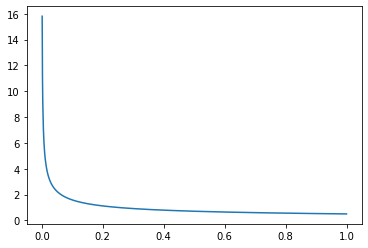

In [ ]:
import scipy.stats as ss

for mag in np.linspace(0.0, 5.9, 1):
    x = np.linspace(0,1,1000)
    y = ss.beta.pdf(x, 0.5, 1)
    plt.plot(x,y);

In [ ]:
np.random.beta(0.1,1)

2.44374293541514e-12

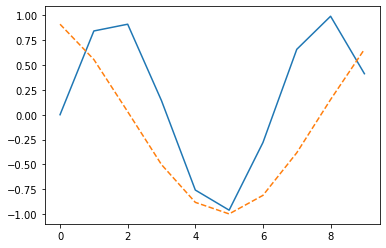

In [ ]:
t = _get_log((2,10))
t = _get_sin((2,10))

# t,_zoomin(t)
plt.plot(t.T)
plt.plot(_zoomin(t, 0.3).T, linestyle='dashed');

In [ ]:
# #export
# def _timewarp(x, magnitude=.1, order=4):
#     '''This is a slow batch tfm on cpu'''
#     if magnitude <= 0: return x
# #     if len(x.shape)==1: x=x.unsqueeze(0) #no support for 1D tensors
#     assert len(x.shape)==2, 'only 2D tensors supported'
#     n_channels, seq_len = x.shape
#     x_device = x.device ## make sure to put outpout on right device
#     x=x.cpu() ## only works on cpu
    
# #    return f
# #     plt.plot(x.T)
# #     plt.plot(np.linspace(0,10), f(np.linspace(0,10)[:, None]).squeeze())
#     new_x = distort_time(x, magnitude=magnitude, smooth=True, order=order)
#     fs = [CubicSpline(np.arange(seq_len), xi, axis=-1) for xi in x]
# #     new_y = f(new_x, )
#     new_y = torch.stack([torch.tensor(fs[i](xi)) for i,xi in enumerate(new_x)] )
#     return new_y.to(x_device)


In [ ]:
# #export
# def _timenoise(x, magnitude=.1, order=4):
#     '''This is a slow batch tfm on cpu'''
#     if magnitude <= 0: return x
# #     if len(x.shape)==1: x=x.unsqueeze(0) #no support for 1D tensors
#     assert len(x.shape)==2, 'only 2D tensors supported'
#     n_channels, seq_len = x.shape
#     x_device = x.device ## make sure to put outpout on right device
#     x=x.cpu() ## only works on cpu
    
# #    return f
# #     plt.plot(x.T)
# #     plt.plot(np.linspace(0,10), f(np.linspace(0,10)[:, None]).squeeze())
#     new_x = distort_time(x, magnitude=magnitude)
#     fs = [CubicSpline(np.arange(seq_len), xi, axis=-1) for xi in x]
# #     new_y = f(new_x, )
#     new_y = torch.stack([torch.tensor(fs[i](xi)) for i,xi in enumerate(new_x)] )
#     return new_y.to(x_device)


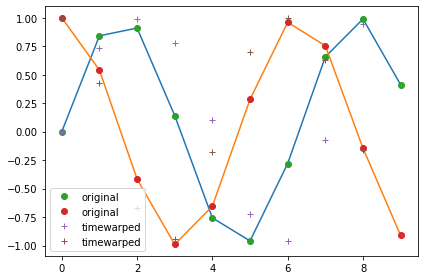

In [ ]:
t1 = torch.tensor([np.sin(x) for x in range(10)])
t2 = torch.tensor([np.cos(x) for x in range(10)])
t3 = torch.stack((t1,t2))
t4 = torch.rand(5,20)

# _timewarp(t1)
for t in [t1.unsqueeze(0),t2.unsqueeze(0),t3,t4]: assert _timewarp(t).shape == t.shape
plt.plot(t3.T);    
plt.plot(t3.T, 'o', label='original')
plt.plot(_timewarp(t3, 0.2).T, '+', label='timewarped')
plt.tight_layout()
plt.legend();

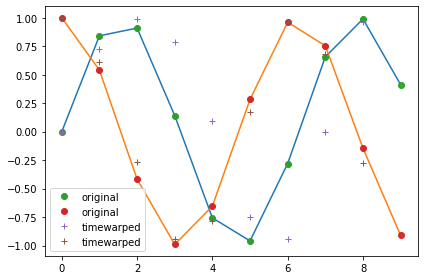

In [ ]:
#cuda
t1 = torch.tensor([np.sin(x) for x in range(10)]).cuda()
t2 = torch.tensor([np.cos(x) for x in range(10)]).cuda()
t3 = torch.stack((t1,t2))
t4 = torch.rand(5,20)

# _timewarp(t1)
for t in [t1.unsqueeze(0),t2.unsqueeze(0),t3,t4]: assert _timewarp(t).shape == t.shape
plt.plot(t3.cpu().T);    
plt.plot(t3.cpu().T, 'o', label='original')
plt.plot(_timewarp(t3, 0.2).cpu().T, '+', label='timewarped')
plt.tight_layout()
plt.legend();

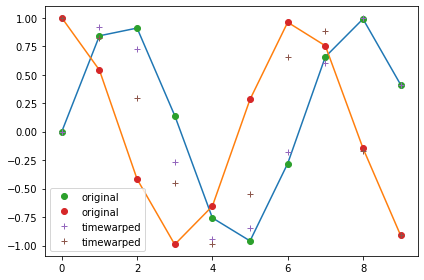

In [ ]:
t1 = torch.tensor([np.sin(x) for x in range(10)])
t2 = torch.tensor([np.cos(x) for x in range(10)])
t3 = torch.stack((t1,t2))
t4 = torch.rand(5,20)

# _timewarp(t1)
for t in [t1.unsqueeze(0),t2.unsqueeze(0),t3,t4]: assert _timewarp(t).shape == t.shape
plt.plot(t3.T);    
plt.plot(t3.T, 'o', label='original')
plt.plot(_timewarp(t3, 0.2).T, '+', label='timewarped')
plt.tight_layout()
plt.legend();

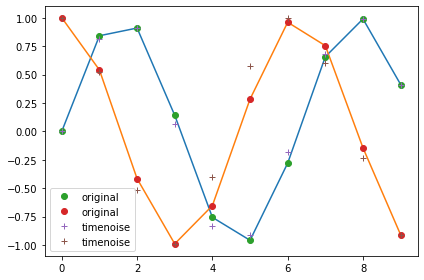

In [ ]:
for t in [t1.unsqueeze(0),t2.unsqueeze(0),t3,t4]: assert _timenormal(t).shape == t.shape
plt.plot(t3.T);    
plt.plot(t3.T, 'o', label='original')
plt.plot(_timenormal(t3, 0.2).T, '+', label='timenoise')
plt.tight_layout()
plt.legend();

In [ ]:
_timewarp(t)

tensor([[ 0.2893,  0.8473,  0.6914,  0.7523,  0.7889,  0.3506,  0.5424,  0.8859,
          0.5487,  0.0973,  0.4916,  0.4886,  0.5717,  0.2582,  0.7046,  0.2410,
         -0.0268,  0.8319,  0.9232,  0.9623],
        [ 0.0443,  0.0387,  0.2487,  0.4346,  0.5097,  0.6510,  0.5731,  0.2551,
          0.9075,  0.6066,  0.2584,  0.8631,  0.6763,  0.3516,  0.5432,  0.2419,
          0.3733,  0.2382,  0.0926,  0.8214],
        [ 0.9127,  0.1074,  0.4477,  0.3843,  0.3048, -0.0161,  0.5583,  0.5356,
          0.0989,  0.7796,  0.3802,  0.7861,  0.1250,  0.8192,  0.6873,  0.7209,
          0.4115,  0.7117,  0.7765,  0.2968],
        [ 0.9471,  0.5725,  0.3567,  0.1555,  0.5502,  0.4497,  0.0190,  1.0138,
          0.9341,  0.6519,  0.8365,  0.6530,  0.5311,  0.9721,  0.2803,  0.3829,
          0.5325,  0.4809,  0.5636,  0.7127],
        [ 0.7208,  0.2256,  0.0439,  0.4931,  0.9462,  0.6683,  0.5415,  0.5776,
          0.4768,  0.2274,  0.4918,  0.4015,  0.3741,  0.8632,  0.6860,  0.7531,
      

### Transforms

We define augmentation `Transforms` for types `TSTensor` and `TSIntTensor`. The augmentation functions are defined for float tensors. In order to use them for discrete timeseries tensors, we cast them to float, apply the augmentations and then cast them back to TSIntTensor.

In [ ]:
# class TimeWarp(Transform):
#     order=200
#     def encodes(self, x:TSTensor):
#         print('timewarp')
#         return _timewarp(x)

In [ ]:
#export
@delegates(Transform.__init__)
class AugTransform(Transform):
    split_idx,init_enc,order,train_setup = 0,True,200,None
    def __init__(self, magnitude=0.1, verbose=False, **kwargs):
        super().__init__(**kwargs)
        self.magnitude=magnitude
        self.verbose = verbose
        
    def __call__(self, x, split_idx=split_idx):
        return super().__call__(x, split_idx=split_idx)

In [ ]:
#export
@delegates()
class YWarp(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('ywarp', self.verbose)
        return _ynoise_warp(x, magnitude=self.magnitude)

In [ ]:
yw=YWarp(magnitude=0.5, order=5, verbose=False)

In [ ]:
yw.magnitude

0.5

In [ ]:
x = TSTensor(torch.ones(2,1,10))

In [ ]:
x

TSTensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])

In [ ]:
yw(TSTensor(torch.ones(2,1,5)), split_idx=0)

TSTensor([[[1.2169, 0.6319, 0.8402, 1.1696, 0.9478]],

        [[1.2169, 0.6319, 0.8402, 1.1696, 0.9478]]])

In [ ]:
# from fastai2.vision.all import *

In [ ]:
class InplaceTransform2(Transform):
    "A `Transform` that modifies in-place and just returns whatever it's passed"
    def _call(self, fn, x, split_idx=None, **kwargs):
        return super()._call(fn,x,split_idx,**kwargs)
#         return x

In [ ]:
class InplaceTransform3(Transform): pass

In [ ]:
def f(x:int): return x+1
tfm1 = Transform(f)
tfm2 = InplaceTransform2(f)
tfm3 = InplaceTransform3(f)
tfm = AugTransform(f)
# tfmp = RandTransform(f)

# tfm(2),tfm(2.0)

In [ ]:
Transform.__repr__??

In [ ]:
# return f'{self.name}: {self.encodes} {self.decodes}'

In [ ]:
AugTransform(enc=f)

f: (int,object) -> f 

In [ ]:
tfm.name, tfm1.name

('AugTransform', 'f')

In [ ]:
#export
class YNormal(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('ynormal', verbose=self.verbose)
        return _ynoise_normal(x)
    
class YNormalMul(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('ynormal', verbose=self.verbose)
        return _ynoise_normal_mul(x)

In [ ]:
ts_sin = TSTensor(_get_sin())

In [ ]:
YNormal(verbose=True)(ts_sin), YNormal(verbose=False)(ts_sin)

ynormal


(TSTensor([[-0.0444,  0.9258,  1.0802,  0.0846, -0.7631, -0.9751, -0.1850,  0.5920,
           0.9856,  0.2547, -0.4872, -0.9265, -0.5356,  0.5678,  0.9834,  0.6729,
          -0.3046, -0.9423, -0.8673,  0.2386]]),
 TSTensor([[ 0.0299,  0.9528,  1.1609, -0.0691, -0.8654, -1.0668, -0.3515,  0.6334,
           0.9570,  0.2632, -0.6453, -0.8143, -0.5222,  0.5012,  0.9318,  0.5375,
          -0.1740, -0.8889, -0.6482,  0.2764]]))

In [ ]:
#export
class YScale(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('yscale', verbose=self.verbose)
        return _yscale(x)

In [ ]:
#export
class YScaleChannel(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('yscale channel', verbose=self.verbose)
        return partial(_yscale, by_channel=True)(x)

In [ ]:
#export
class TimeWarp(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('timewarp', verbose=self.verbose)
        return _timewarp(x)

In [ ]:
#export
class TimeNormal(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv(f'timenormal {x.shape}', verbose=self.verbose)
        return _timenormal(x, magnitude=self.magnitude)

In [ ]:
#export
def all_noise_augs(magnitude=0.1, verbose=False):
    kwargs = {'magnitude':magnitude, 'verbose':verbose}
    return [YWarp(**kwargs), YNormal(**kwargs), YScale(**kwargs),
           TimeWarp(**kwargs), TimeNormal(**kwargs)]

Experimental, include TSIntTensor 
- apply regular float transforms, but round back to int
- that might or might not make sense, application dependend

In [ ]:
retain_type??

In [ ]:
Transform._do_call??

In [ ]:
@TimeNormal
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))
#     print(x)
#     x_encoded = _timenormal(x.float(), magnitude=self.magnitude)
#     print(type(x_encoded))
#     return _timenormal(x.float(), magnitude=self.magnitude).int()
#     return retain_type(x, self.__call__(TSTensor(x.float())).int())


In [ ]:
#export
@YWarp
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))

@YNormal
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))
    
@YScale
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))

@TimeWarp
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))


In [ ]:
tfms = all_noise_augs()

In [ ]:
tint = TSIntTensor(np.random.randint(0, high=5, size=(1,10)))
tfloat = TSTensor(np.random.randn(1,10))

In [ ]:
tint, tfloat
tw = TimeWarp()

In [ ]:
tw(tint)

TSIntTensor([[1, 1, 0, 3, 1, 0, 3, 3, 3, 3]], dtype=torch.int32)

In [ ]:
tn = TimeNormal()

In [ ]:
tn(tint)

TSIntTensor([[1, 2, 0, 4, 1, 0, 4, 3, 4, 3]])

In [ ]:
tfms

[YWarp: (TSIntTensor,object) -> encodes
 (TSTensor,object) -> encodes , YNormal: (TSIntTensor,object) -> encodes
 (TSTensor,object) -> encodes , YScale: (TSIntTensor,object) -> encodes
 (TSTensor,object) -> encodes , TimeWarp: (TSIntTensor,object) -> encodes
 (TSTensor,object) -> encodes , TimeNormal: (TSIntTensor,object) -> encodes
 (TSTensor,object) -> encodes ]

In [ ]:
tint

TSIntTensor([[1, 2, 0, 4, 1, 0, 4, 3, 4, 3]])

In [ ]:
compose_tfms(tint, tfms)

TSIntTensor([[0, 0, 0, 1, 0, 1, 3, 1, 2, 1]], dtype=torch.int32)

In [ ]:
for i in range(len(tfms)):
    print(tfms[i](tint))

TSIntTensor([[1, 2, 0, 4, 1, 0, 3, 2, 3, 3]], dtype=torch.int32)
TSIntTensor([[0, 2, 0, 3, 1, 0, 3, 2, 3, 3]], dtype=torch.int32)
TSIntTensor([[1, 2, 0, 4, 1, 0, 4, 3, 4, 3]], dtype=torch.int32)
TSIntTensor([[1, 1, 0, 4, 0, 0, 4, 2, 4, 3]], dtype=torch.int32)
TSIntTensor([[1, 2, 0, 4, 1, 0, 4, 3, 4, 3]])


In [ ]:
yw(tint)

TSIntTensor([[4, 0, 0, 1, 3, 0, 1, 3, 1, 0]], dtype=torch.int32)

#### Zoom

In [ ]:
#export
class Zoomin(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('zoomin', verbose=self.verbose)
        return _zoomin(x, magnitude=self.magnitude)
    
class Zoomout(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('zoomout', verbose=self.verbose)
        return _zoomout(x, magnitude=self.magnitude)
    
class RandZoom(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('randzoom', verbose=self.verbose)
        return _randzoom(x, magnitude=self.magnitude)
    
class RandTimesteps(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('randtimestep', verbose=self.verbose)
        return _randtimesteps(x, magnitude=self.magnitude)

In [ ]:
#export
@Zoomin
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))

@Zoomout
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))

@RandZoom
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))

@RandTimesteps
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))

In [ ]:
#export
def all_zoom_augs(magnitude=0.1, verbose=False):
    kwargs = {'magnitude':magnitude, 'verbose':verbose}
    return [Zoomin(**kwargs), Zoomout(**kwargs), RandZoom(**kwargs),
           RandTimesteps(**kwargs)]

In [ ]:
# #export
# _timestepzero = partial(_erase)
# _timestepmean = partial(_erase, mean=True)
# _cutout = partial(_erase, window=True)
# _crop = partial(_erase, window=True, complement=True)
# _randomcrop = partial(_erase, window=True, rand=True, complement=True)
# _centercrop = partial(_erase, window=True, center=True,complement=True)
# _maskout = partial(_erase, mask=True)
# _dimout = partial(_erase, dim=True)

In [ ]:
#export
class TimestepZero(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('timestepzero', verbose=self.verbose)
        return _timestepzero(x, magnitude=self.magnitude)

class TimestepMean(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('timestepmean', verbose=self.verbose)
        return _timestepmean(x, magnitude=self.magnitude)
    
class Cutout(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('cutout', verbose=self.verbose)
        return _cutout(x, magnitude=self.magnitude)

class Crop(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('crop', verbose=self.verbose)
        return _crop(x, magnitude=self.magnitude)
    
class RandomCrop(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('randomcrop', verbose=self.verbose)
        return _randomcrop(x, magnitude=self.magnitude)

class CenterCrop(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('centercrop', verbose=self.verbose)
        return _centercrop(x, magnitude=self.magnitude)
    
class Maskout(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('maskout', verbose=self.verbose)
        return _maskout(x, magnitude=self.magnitude)
    
class Dimout(AugTransform):
    order=200
    def encodes(self, x:TSTensor):
        pv('dimout', verbose=self.verbose)
        return _dimout(x, magnitude=self.magnitude)

In [ ]:
#export
@TimestepZero
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))
@TimestepMean
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))
@Cutout
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))
@Crop
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))
@RandomCrop
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))
@CenterCrop
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))
@Maskout
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))
@Dimout
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))

In [ ]:
crop = Crop(magnitude=.4, verbose=True)
dimout = Dimout(magnitude=0.5, verbose=True)

In [ ]:
t = torch.rand((3,10))
t.shape

torch.Size([3, 10])

In [ ]:
assert torch.allclose(t, crop(t))
assert torch.allclose(t, dimout(t))

In [ ]:
crop(t)

tensor([[0.4786, 0.7300, 0.1713, 0.3524, 0.7731, 0.6006, 0.1545, 0.2792, 0.2164,
         0.5862],
        [0.1266, 0.9085, 0.4959, 0.4366, 0.9441, 0.3677, 0.4607, 0.6006, 0.4505,
         0.4862],
        [0.7446, 0.1279, 0.0816, 0.3811, 0.8848, 0.8263, 0.3784, 0.5897, 0.3875,
         0.6648]])

In [ ]:
crop(TSTensor(t))

crop


TSTensor([[[0.0000, 0.7300, 0.1713, 0.3524, 0.7731, 0.6006, 0.1545, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.9085, 0.4959, 0.4366, 0.9441, 0.3677, 0.4607, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.1279, 0.0816, 0.3811, 0.8848, 0.8263, 0.3784, 0.0000,
          0.0000, 0.0000]]])

In [ ]:
dimout(TSTensor(t))

dimout


TSTensor([[[0.4786, 0.7300, 0.1713, 0.3524, 0.7731, 0.6006, 0.1545, 0.2792,
          0.2164, 0.5862],
         [0.1266, 0.9085, 0.4959, 0.4366, 0.9441, 0.3677, 0.4607, 0.6006,
          0.4505, 0.4862],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]]])

In [ ]:
#export
def all_erasing_augs(magnitude=0.1, verbose=False):
    kwargs = {'magnitude':magnitude, 'verbose':verbose}
    return [Dimout(**kwargs), Cutout(**kwargs), TimestepZero(**kwargs), Crop(**kwargs), 
            RandomCrop(**kwargs), Maskout(**kwargs)]

In [ ]:
tfms = all_noise_augs()
tfms = all_zoom_augs()
tfms = all_erasing_augs(magnitude=0.2, verbose=True)

In [ ]:
L(tfms)

(#6) [Dimout: (TSTensor,object) -> encodes ,Cutout: (TSTensor,object) -> encodes ,TimestepZero: (TSTensor,object) -> encodes ,Crop: (TSTensor,object) -> encodes ,RandomCrop: (TSTensor,object) -> encodes ,Maskout: (TSTensor,object) -> encodes ]

In [ ]:
ts = TSTensor(torch.ones(6,10))

In [ ]:
compose_tfms(ts, tfms)

dimout
cutout
timestepzero
crop
randomcrop
maskout


TSTensor([[[0., 1., 1., 0., 1., 1., 1., 1., 0., 0.],
         [0., 1., 1., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 1., 0., 1., 1., 1., 0., 0., 0.],
         [0., 1., 0., 0., 1., 1., 1., 1., 0., 0.],
         [0., 0., 1., 0., 1., 1., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [ ]:
pipe = Pipeline(tfms, split_idx=0)

In [ ]:
pipe.fs

(#6) [Dimout: (TSTensor,object) -> encodes ,Cutout: (TSTensor,object) -> encodes ,TimestepZero: (TSTensor,object) -> encodes ,Crop: (TSTensor,object) -> encodes ,RandomCrop: (TSTensor,object) -> encodes ,Maskout: (TSTensor,object) -> encodes ]

In [ ]:
compose_tfms(ts, tfms)

dimout
cutout
timestepzero
crop
randomcrop
maskout


TSTensor([[[0., 0., 1., 0., 1., 1., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 1., 1., 1., 1., 0., 0.],
         [0., 0., 1., 0., 1., 1., 1., 1., 0., 0.],
         [0., 0., 1., 0., 1., 1., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 1., 1., 1., 0., 0.]]])

In [ ]:
pipe(ts)

dimout
cutout
timestepzero
crop
randomcrop
maskout


TSTensor([[[0., 0., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [ ]:
erasing = all_erasing_augs(magnitude=0.4, verbose=True)

In [ ]:
t = _get_sin((1,10))

In [ ]:
t

tensor([[ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568, -0.9589, -0.2794,  0.6570,
          0.9894,  0.4121]])

In [ ]:
Cutout(verbose=True)(TSTensor(t))

cutout


TSTensor([[ 0.0000,  0.8415,  0.0000,  0.1411, -0.7568, -0.9589, -0.2794,  0.6570,
          0.9894,  0.4121]])

In [ ]:
t = torch.rand((16,8,2))

In [ ]:
Pipeline(erasing, split_idx=0)(TSTensor(t))

dimout
cutout
timestepzero
crop
randomcrop
maskout


TSTensor([[[0.0000, 0.0000],
         [0.0000, 0.9919],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0122],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.6885],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.6140],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.3793],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.8519],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.3384],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.1962],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0469],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 

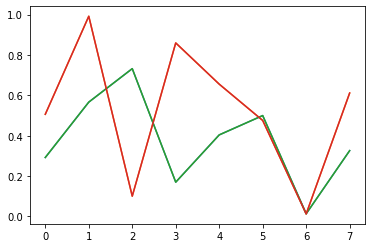

In [ ]:
plt.plot(t[0])
plt.plot(Pipeline(erasing)(TSTensor(t))[0])

In [ ]:
Dimout(magnitude=0.5)(TSTensor(t))
Dimout(magnitude=0.5)(TSTensor(torch.rand((3,10))))

TSTensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.7742, 0.3891, 0.5095, 0.7748, 0.3330, 0.2676, 0.8140, 0.9026,
          0.1077, 0.8831],
         [0.3525, 0.7454, 0.0459, 0.4207, 0.4723, 0.2412, 0.2986, 0.6538,
          0.3560, 0.6950]]])

In [ ]:
_timestepzero(t)

tensor([[[0.2918, 0.5060],
         [0.5663, 0.9919],
         [0.7322, 0.1001],
         [0.1695, 0.8596],
         [0.4038, 0.6553],
         [0.4996, 0.4754],
         [0.0129, 0.0122],
         [0.3258, 0.6113]],

        [[0.9005, 0.9014],
         [0.0528, 0.6885],
         [0.6313, 0.7499],
         [0.4913, 0.4162],
         [0.8340, 0.0382],
         [0.7028, 0.9746],
         [0.8587, 0.6140],
         [0.6892, 0.3380]],

        [[0.3947, 0.8043],
         [0.7654, 0.3793],
         [0.5965, 0.3576],
         [0.3293, 0.1729],
         [0.7621, 0.8402],
         [0.5369, 0.0035],
         [0.1624, 0.8519],
         [0.2373, 0.1646]],

        [[0.2356, 0.9415],
         [0.0513, 0.3384],
         [0.2497, 0.9257],
         [0.2802, 0.5098],
         [0.3100, 0.7145],
         [0.2751, 0.0249],
         [0.7424, 0.1962],
         [0.2329, 0.4692]],

        [[0.6906, 0.9937],
         [0.8503, 0.0469],
         [0.7461, 0.5447],
         [0.6808, 0.4887],
         [0.3752, 0.

In [ ]:
AugTransform(_timestepzero)(TSTensor(t))

TSTensor([[[0.2918, 0.5060],
         [0.5663, 0.9919],
         [0.7322, 0.1001],
         [0.1695, 0.8596],
         [0.4038, 0.6553],
         [0.4996, 0.4754],
         [0.0129, 0.0122],
         [0.3258, 0.6113]],

        [[0.9005, 0.9014],
         [0.0528, 0.6885],
         [0.6313, 0.7499],
         [0.4913, 0.4162],
         [0.8340, 0.0382],
         [0.7028, 0.9746],
         [0.8587, 0.6140],
         [0.6892, 0.3380]],

        [[0.3947, 0.8043],
         [0.7654, 0.3793],
         [0.5965, 0.3576],
         [0.3293, 0.1729],
         [0.7621, 0.8402],
         [0.5369, 0.0035],
         [0.1624, 0.8519],
         [0.2373, 0.1646]],

        [[0.2356, 0.9415],
         [0.0513, 0.3384],
         [0.2497, 0.9257],
         [0.2802, 0.5098],
         [0.3100, 0.7145],
         [0.2751, 0.0249],
         [0.7424, 0.1962],
         [0.2329, 0.4692]],

        [[0.6906, 0.9937],
         [0.8503, 0.0469],
         [0.7461, 0.5447],
         [0.6808, 0.4887],
         [0.3752, 

In [ ]:
augs = all_noise_augs()

In [ ]:
augs

[YWarp: (TSTensor,object) -> encodes ,
 YNormal: (TSTensor,object) -> encodes ,
 YScale: (TSTensor,object) -> encodes ,
 TimeWarp: (TSTensor,object) -> encodes ,
 TimeNormal: (TSTensor,object) -> encodes ]

In [ ]:
augs = all_erasing_augs()

In [ ]:
augs

[Dimout: (TSTensor,object) -> encodes ,
 Cutout: (TSTensor,object) -> encodes ,
 TimestepZero: (TSTensor,object) -> encodes ,
 Crop: (TSTensor,object) -> encodes ,
 RandomCrop: (TSTensor,object) -> encodes ,
 Maskout: (TSTensor,object) -> encodes ]

In [ ]:
augs = all_zoom_augs()

In [ ]:
augs

[Zoomin: (TSTensor,object) -> encodes ,
 Zoomout: (TSTensor,object) -> encodes ,
 RandZoom: (TSTensor,object) -> encodes ,
 RandTimesteps: (TSTensor,object) -> encodes ]

In [ ]:
augs[0](TSTensor(torch.ones(2,3,10)), split_idx=None).shape

torch.Size([2, 3, 10])

In [ ]:
ts_ones = TSTensor(torch.ones(1,10))
compose_tfms(ts_ones, [TimeWarp(), YScale()])
compose_tfms(ts_ones, augs)


TSTensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [ ]:
#export
class RandAugment(AugTransform):
    def __init__(self, N=2, magnitude=0.2, tfms=None, **kwargs):
        order=200
        super().__init__(**kwargs)
        self.N = N
        print(f'tfms {tfms}')
        self.tfms = tfms
        if tfms is None: self.tfms = all_noise_augs(magnitude)
            
    def encodes(self, x:TSTensor):
        fs = np.random.choice(self.tfms, self.N, replace=False)
        return compose_tfms(x, fs)
    

tfms None


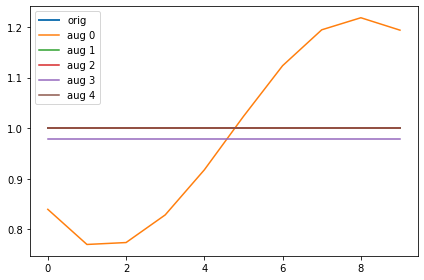

In [ ]:
ts_ones = TSTensor(torch.ones(1,10))
plt.plot(ts_ones.T, linewidth=2, label='orig')
rand_aug = RandAugment(N=2, magnitude=0.2)
for i in range(5):
    plt.plot(rand_aug(ts_ones).T, label=f'aug {i}')
plt.legend()
plt.tight_layout()

tfms [Dimout: (TSTensor,object) -> encodes , Cutout: (TSTensor,object) -> encodes , TimestepZero: (TSTensor,object) -> encodes , Crop: (TSTensor,object) -> encodes , RandomCrop: (TSTensor,object) -> encodes , Maskout: (TSTensor,object) -> encodes ]
cutout
crop
timestepzero
crop
maskout
timestepzero
timestepzero
maskout
timestepzero
cutout


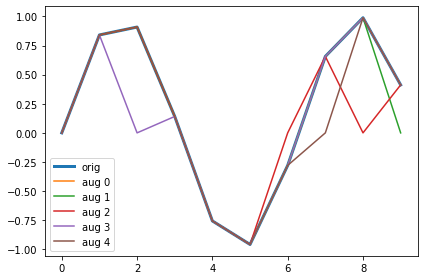

In [ ]:
t_sinus = _get_sin((1,10))
ts_sinus = TSTensor(t_sinus)
plt.plot(ts_sinus.T, linewidth=3, label='orig')
# rand_aug = RandAugment(N=2, magnitude=0.2, tfms=all_noise_augs()+all_erasing_augs(verbose=True)+
#                        all_zoom_augs())
rand_aug = RandAugment(N=2, magnitude=0.2, tfms=all_erasing_augs(verbose=True))

for i in range(5):
    plt.plot(rand_aug(ts_sinus).T, label=f'aug {i}')
plt.legend()
plt.tight_layout()

In [ ]:
rand_aug.tfms[0].verbose

True

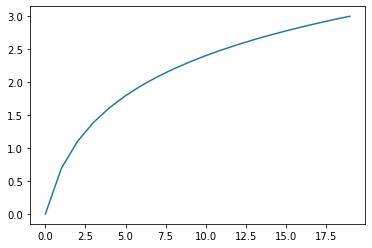

In [ ]:
plt.plot([np.log(x+1) for x in range(20)])

In [ ]:
def _get_sin(dims=(1,20)): return torch.tensor([np.sin(x) for x in np.arange(dims[1])]).unsqueeze(0)
def _get_log(dims=(1,20)): return torch.tensor([np.log(x+1) for x in np.arange(dims[1])]).unsqueeze(0)


tfms None


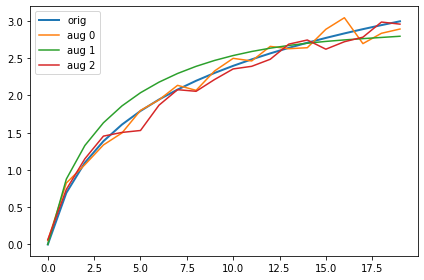

In [ ]:
ts = TSTensor(_get_log())
plt.plot(ts.T, linewidth=2, label='orig')
rand_aug = RandAugment(N=2, magnitude=0.5)
for i in range(3):
    plt.plot(rand_aug(ts).T, label=f'aug {i}')
plt.legend()
plt.tight_layout()

In [ ]:
ts_ones = TSTensor(torch.ones(1,50))
tn = TimeNormal(0.4)
print(tn.magnitude)
(TSTensor(torch.ones(1,5)))

0.4


TSTensor([[1., 1., 1., 1., 1.]])

In [ ]:
ts_ones = TSTensor(torch.ones(1,10))
compose_tfms(ts_ones, [TimeWarp(), YScale()])

TSTensor([[1.0021, 1.0021, 1.0021, 1.0021, 1.0021, 1.0021, 1.0021, 1.0021, 1.0021,
         1.0021]])

In [ ]:
# class YWarp(Transform): pass
# @YWarp
# def encodes(self, x:TSTensor): return _ynoise_warp(x)
# @YWarp
# def encodes(self, x:np.ndarray): ##just for testing
# #     print(type(x))
#     return _ynoise_warp(TSTensor(torch.tensor(x)))

In [ ]:
_ynoise_warp(TSTensor(torch.ones(1,5)))

TSTensor([[1.0278, 0.9753, 0.9921, 0.9674, 0.7903]])

In [ ]:
print(YWarp()(np.ones(shape=(1,5))))
print(YWarp()(TSTensor(torch.ones(1,5))))

TSTensor([[1.0188, 1.0305, 1.0487, 1.0787, 1.1257]])
TSTensor([[1.0599, 0.8171, 0.6883, 0.7319, 1.0066]])


In [ ]:
YWarp()

YWarp: (ndarray,object) -> encodes
(TSTensor,object) -> encodes 

In [ ]:
isinstance(np.ones((1,5)), np.ndarray)

True

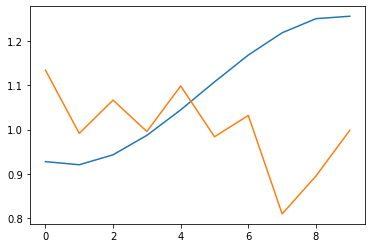

In [ ]:
ts_tensor = TSTensor(torch.ones(1,10))
plt.plot(YWarp()(ts_tensor).T)
plt.plot(YNormal()(ts_tensor).T);

In [ ]:
all_noise_augs(magnitude=0.5)

[YWarp: (TSTensor,object) -> encodes ,
 YNormal: (TSTensor,object) -> encodes ,
 YScale: (TSTensor,object) -> encodes ,
 TimeWarp: (TSTensor,object) -> encodes ,
 TimeNormal: (TSTensor,object) -> encodes ]

In [ ]:
RandAugment(N=2, magnitude=0.2)


tfms None


RandAugment: (TSTensor,object) -> encodes 

### Augmix

In [ ]:
#export
class Augmix(AugTransform):
    def __init__(self, N=3, magnitude=0.2, k=3, alpha=1, tfms=None, verbose=False, **kwargs):
        '''
        N: number of operations per update
        k: number of update operations
        alpha: beta and dirichlet parameter
        '''
        order=200
        super().__init__(**kwargs)
        self.N, self.k, self.alpha, self.verbose = N, k, alpha, verbose
        print(f'tfms {tfms}')
        self.tfms = tfms
        if tfms is None: self.tfms = all_noise_augs(magnitude, verbose=verbose)
            
    def encodes(self, x:TSTensor):
        x_aug = torch.zeros_like(x)
        weights = np.random.dirichlet([self.alpha]*self.N)
        m = np.random.beta(self.alpha, self.alpha)
        pv(f'weights {weights}, m {m}', self.verbose)
        for i in range(self.k):
            fs = np.random.choice(self.tfms, self.N, replace=False)
            n = np.random.randint(self.N)
            pv(f'ops in step {i} {fs[:n+1]}', self.verbose)
            x_aug += weights[i]*compose_tfms(x, fs[:n+1])
        return m*x + (1-m)*x_aug
    

In [ ]:
@Augmix
def encodes(self, x:TSIntTensor):
    return cast(self.__call__(TSTensor(x.float())).int(), type(x))

In [ ]:
augmix = Augmix(magnitude=0.4, verbose=True)

tfms None


In [ ]:
augmix.verbose

True

In [ ]:
augmix.tfms

[YWarp: (TSTensor,object) -> encodes ,
 YNormal: (TSTensor,object) -> encodes ,
 YScale: (TSTensor,object) -> encodes ,
 TimeWarp: (TSTensor,object) -> encodes ,
 TimeNormal: (TSTensor,object) -> encodes ]

In [ ]:
t = _get_sin()

In [ ]:
ts = TSTensor(t)

In [ ]:
ts

TSTensor([[ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568, -0.9589, -0.2794,  0.6570,
          0.9894,  0.4121, -0.5440, -1.0000, -0.5366,  0.4202,  0.9906,  0.6503,
         -0.2879, -0.9614, -0.7510,  0.1499]])

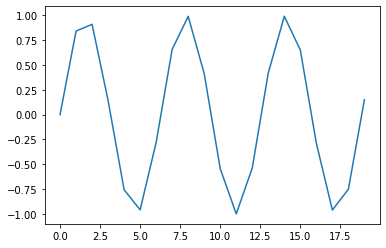

In [ ]:
plt.plot(t[0])

In [ ]:
augmix(ts)

weights [0.39155665 0.28130843 0.32713492], m 0.248788925080704
ops in step 0 [TimeNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSTensor,object) -> encodes
 YNormal: (TSTensor,object) -> encodes ]
timenormal torch.Size([1, 20])
timewarp
ynormal
ops in step 1 [YScale: (TSTensor,object) -> encodes ]
yscale
ops in step 2 [YNormal: (TSTensor,object) -> encodes
 TimeWarp: (TSTensor,object) -> encodes ]
ynormal
timewarp


TSTensor([[ 0.0174,  0.8793,  0.6597, -0.1984, -0.6847, -0.4856,  0.0198,  0.4080,
          0.4307,  0.0182, -0.3806, -0.5094, -0.0358,  0.4884,  0.7605,  0.3043,
         -0.4251, -1.0050, -0.7258,  0.1748]])

weights [0.51738994 0.04861416 0.43399591], m 0.34325435535072396
ops in step 0 [YNormal: (TSTensor,object) -> encodes
 YWarp: (TSTensor,object) -> encodes
 TimeWarp: (TSTensor,object) -> encodes ]
ynormal
ywarp
timewarp
ops in step 1 [TimeWarp: (TSTensor,object) -> encodes
 TimeNormal: (TSTensor,object) -> encodes ]
timewarp
timenormal torch.Size([1, 20])
ops in step 2 [YNormal: (TSTensor,object) -> encodes
 YScale: (TSTensor,object) -> encodes
 YWarp: (TSTensor,object) -> encodes ]
ynormal
yscale
ywarp


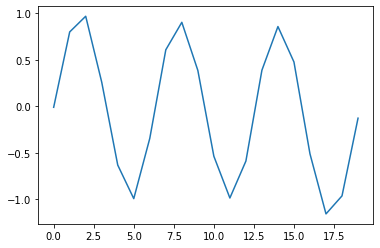

In [ ]:
plt.plot(augmix(ts)[0])

tfms [Dimout: (TSTensor,object) -> encodes , Cutout: (TSTensor,object) -> encodes , TimestepZero: (TSTensor,object) -> encodes , Crop: (TSTensor,object) -> encodes , RandomCrop: (TSTensor,object) -> encodes , Maskout: (TSTensor,object) -> encodes ]
weights [0.1852274  0.71097872 0.10379388], m 0.608942007554125
ops in step 0 [RandomCrop: (TSTensor,object) -> encodes
 Cutout: (TSTensor,object) -> encodes  Crop: (TSTensor,object) -> encodes ]
ops in step 1 [RandomCrop: (TSTensor,object) -> encodes ]
ops in step 2 [TimestepZero: (TSTensor,object) -> encodes ]
weights [0.16138514 0.56890132 0.26971354], m 0.30319999387171676
ops in step 0 [TimestepZero: (TSTensor,object) -> encodes
 RandomCrop: (TSTensor,object) -> encodes ]
ops in step 1 [Dimout: (TSTensor,object) -> encodes
 TimestepZero: (TSTensor,object) -> encodes
 Crop: (TSTensor,object) -> encodes ]
ops in step 2 [Crop: (TSTensor,object) -> encodes
 TimestepZero: (TSTensor,object) -> encodes ]
weights [0.02005121 0.35518342 0.624765

''

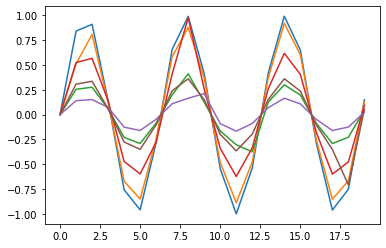

In [ ]:
ts = TSTensor(_get_sin())
plt.plot(ts[0])
tfms = all_erasing_augs(magnitude=0.9)
augmix = Augmix(magnitude=0.5, verbose=True, tfms=tfms)
for i in range(5):
    plt.plot(augmix(ts)[0])
;

### More Augments

In [ ]:
from scipy.ndimage import convolve1d

NOTE: scipy/numpy convolve1d/convolve flips the kernel!

In [ ]:
convolve1d()

In [ ]:
#export
class TSBlur(Transform):
    "Blurs a sequence applying a filter of type [1, 0..., 1]"
    order = 90
    def __init__(self, magnitude=.05, ex=None, **kwargs): self.magnitude, self.ex = magnitude, ex
    def encodes(self, o: TSTensor):
        if self.magnitude <= 0: return o
        if self.magnitude == 3:  filterargs = np.array([1, 0, 1])
        else: 
            magnitude = tuple((3, 3 + int(self.magnitude * 4)))
            n_zeros = int(np.random.choice(np.arange(magnitude[0], magnitude[1] + 1, 2))) - 2
            filterargs = np.array([1] + [0] * n_zeros + [1])
        w = filterargs * np.random.rand(len(filterargs))
        w = w / w.sum()
        output = o.new(convolve1d(o.cpu(), w, mode='nearest'))
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

filterargs [1, random number of zeroes, 1]

In [ ]:
magnitude = tuple((3, 3 + int(0.5 * 4)))

In [ ]:
magnitude

(3, 5)

In [ ]:
n_zeros = int(np.random.choice(np.arange(magnitude[0], magnitude[1] + 1, 2))) - 2

In [ ]:
n_zeros

3

In [ ]:
filterargs = np.array([1] + [0] * n_zeros + [1])

In [ ]:
filterargs

array([1, 0, 0, 0, 1])

In [ ]:
w = filterargs * np.random.rand(len(filterargs))

In [ ]:
w = w/w.sum() 

In [ ]:
w

array([0.25265378, 0.        , 0.        , 0.        , 0.74734622])

In [ ]:
t = torch.rand((2,10))

In [ ]:
t.new(convolve1d(t, w, mode='nearest')).shape

torch.Size([2, 10])

In [ ]:
t= _get_sin()

In [ ]:
t

tensor([[ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568, -0.9589, -0.2794,  0.6570,
          0.9894,  0.4121, -0.5440, -1.0000, -0.5366,  0.4202,  0.9906,  0.6503,
         -0.2879, -0.9614, -0.7510,  0.1499]])

In [ ]:
convolve1d(t, w, mode='nearest')

array([[ 0.22973743,  0.0356545 , -0.191209  ,  0.3865943 ,  0.6089646 ,
         0.27145565, -0.31562838, -0.61252517, -0.3462691 ,  0.23834515,
         0.603826  ,  0.414152  , -0.15629144, -0.58304125, -0.4737456 ,
         0.07110954,  0.55058694,  0.52385724, -0.17729641, -0.68062973]],
      dtype=float32)

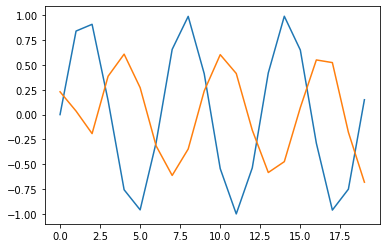

In [ ]:
plt.plot(t[0])
plt.plot(t.new(convolve1d(t,w,mode='nearest'))[0])

In [ ]:
x = np.array([5,2,0,7,9])
w = np.array([1,3])

In [ ]:
convolve1d(x,w, mode='nearest', axis=0)

array([17,  6,  7, 30, 36])

In [ ]:
np.convolve(x,w)

array([ 5, 17,  6,  7, 30, 27])

In [ ]:
import torch

In [ ]:
c1d = torch.nn.Conv1d(1,1,3)

In [ ]:
t = torch.ones((10))

In [ ]:
c1d(t)

tensor([[[1.2395, 1.2395, 1.2395, 1.2395, 1.2395, 1.2395, 1.2395, 1.2395]]],
       grad_fn=<SqueezeBackward1>)

In [ ]:
w=torch.tensor([3.,1.])

In [ ]:
t = torch.tensor([0.,1,2,3,4,5,6])[None, None,:]

In [ ]:
w

tensor([3, 1])

In [ ]:

torch.functional.F.conv1d(t, w[None, None, :])

tensor([[[ 1.,  5.,  9., 13., 17., 21.]]])

In [ ]:
t = np.random.randn(1000)
k = np.random.randn(5)

In [ ]:
%%timeit
np.convolve(t,k, 'same')

6.84 µs ± 76.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [ ]:
%%timeit
convolve1d(t,k)

27.5 µs ± 160 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
assert np.convolve(t,k, 'same') == convolve1d(t,k)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# First a 1-D  Gaussian
t = np.linspace(-10, 10, 30)
bump = np.exp(-0.1*t**2)
bump /= np.trapz(bump) # normalize the integral to 1

# make a 2-D kernel out of it
kernel = bump[:, np.newaxis] * bump[np.newaxis, :]

In [ ]:
t

array([-10.        ,  -9.31034483,  -8.62068966,  -7.93103448,
        -7.24137931,  -6.55172414,  -5.86206897,  -5.17241379,
        -4.48275862,  -3.79310345,  -3.10344828,  -2.4137931 ,
        -1.72413793,  -1.03448276,  -0.34482759,   0.34482759,
         1.03448276,   1.72413793,   2.4137931 ,   3.10344828,
         3.79310345,   4.48275862,   5.17241379,   5.86206897,
         6.55172414,   7.24137931,   7.93103448,   8.62068966,
         9.31034483,  10.        ])

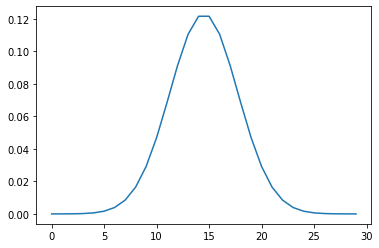

In [ ]:
plt.plot(bump)

In [ ]:
bump.sum()

1.0000055861957333

In [ ]:
kernel

array([[3.12055828e-11, 1.18196079e-10, 4.07063015e-10, 1.27470010e-09,
        3.62946155e-09, 9.39645807e-09, 2.21194316e-08, 4.73447194e-08,
        9.21418511e-08, 1.63053498e-07, 2.62356067e-07, 3.83830873e-07,
        5.10594930e-07, 6.17590908e-07, 6.79224108e-07, 6.79224108e-07,
        6.17590908e-07, 5.10594930e-07, 3.83830873e-07, 2.62356067e-07,
        1.63053498e-07, 9.21418511e-08, 4.73447194e-08, 2.21194316e-08,
        9.39645807e-09, 3.62946155e-09, 1.27470010e-09, 4.07063015e-10,
        1.18196079e-10, 3.12055828e-11],
       [1.18196079e-10, 4.47686339e-10, 1.54181554e-09, 4.82812820e-09,
        1.37471595e-08, 3.55905707e-08, 8.37808447e-08, 1.79325611e-07,
        3.49001831e-07, 6.17590908e-07, 9.93715088e-07, 1.45382012e-06,
        1.93395903e-06, 2.33922322e-06, 2.57266871e-06, 2.57266871e-06,
        2.33922322e-06, 1.93395903e-06, 1.45382012e-06, 9.93715088e-07,
        6.17590908e-07, 3.49001831e-07, 1.79325611e-07, 8.37808447e-08,
        3.55905707e-08,

In [ ]:
from scipy.ndimage import gaussian_filter

In [ ]:
gaussian_filter(np.array([1,0,1]), -2, mode='nearest')

array([1, 0, 1])

In [ ]:
def _apply_kernel(x, k, sp=False):
    '''
    `np.convolve` pads x with zeros, correpsonds to mode 'constant' with cval=0 in `convolve1d`
    `convolve1d` is slower, but offers more padding options that might make more sense
    `convolved1` pads on the right in the case of a kernel of even size, `np.convolve` on the left
    '''
#     output = np.convolve(x,k, mode='same') if not sp else convolve1d(x,k, mode='constant')
    output = np.convolve(x,k, mode='same') if not sp else convolve1d(x,k, mode='nearest')
#     output = convolve1d(x,k, mode='nearest')
    return output

In [ ]:
%%timeit 
_apply_kernel(t[0], [0.5, 0, 0.5])

23.7 µs ± 154 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%%timeit 
_apply_kernel(t[0], [0.5, 0, 0.5], sp=True)

40.4 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
t = _get_sin()

In [ ]:
gaussian_filter()

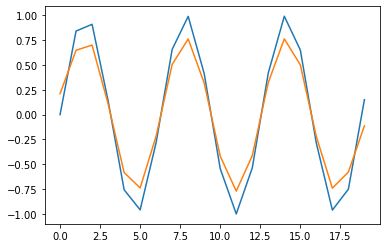

In [ ]:
plt.plot(t[0])
plt.plot(_apply_kernel(t[0], [0.25, 0.5, 0.25]))

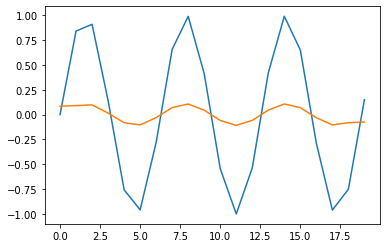

In [ ]:
plt.plot(t[0])
b = 0.1
plt.plot(_apply_kernel(t[0], [b, 0, b], sp=True))

In [ ]:
k = [0.5,0,0,0.5]
t=torch.ones((1,10))
print(t)
print(_apply_kernel(t[0], k))
print(_apply_kernel(t[0], k, sp=True))

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
[0.5 0.5 1.  1.  1.  1.  1.  1.  1.  0.5]
[0.5 1.  1.  1.  1.  1.  1.  1.  0.5 0.5]


In [ ]:
convolve1d(t[0], k, mode='constant')

array([0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.5], dtype=float32)

In [ ]:
ns = tuple((3, 3 + int(1.8) * 4))

In [ ]:
ns

(3, 7)

In [ ]:
n_zeros = int(np.random.choice(np.arange(ns[0], ns[1] + 1, 2))) - 2
n_zeros

3

In [ ]:
n_

In [ ]:
def _create_blur_filter(x, magnitude=0.1):
    '''
    create a 1d filter for blurring, kernel size 3,5,7
    '''
    filter_len = np.random.choice(np.arange(3, 9, 2))
    filter = ([1, *[0]*(filter_len-2), 1]) 
    filter *= np.random.rand(filter_len)
    filter = np.array(filter)/filter.sum() * (1-magnitude)
    print(filter)
    return filter
    
    

In [ ]:
def _create_gaussian_filter(x, magnitude=0.1):
    '''
    create a 1d filter for blurring, kernel size 3,5,7
    '''
    filter_len = np.random.choice(np.arange(3, 9, 2))
    filter = ([1, *[0]*(filter_len-2), 1]) 
    filter *= np.random.rand(filter_len)
    filter = np.array(filter)/filter.sum() * (1-magnitude)
    print(filter)
    return filter
    
    

In [ ]:
_create_blur_filter(t)

[0.01072345 0.         0.         0.         0.88927655]


array([0.01072345, 0.        , 0.        , 0.        , 0.88927655])

[0.3370296 0.        0.        0.        0.        0.        0.1629704]


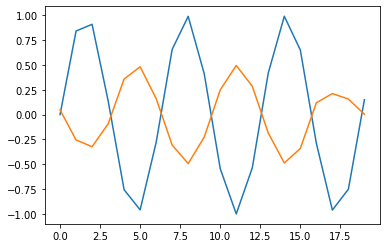

In [ ]:
plt.plot(t[0])
plt.plot(_apply_kernel(t[0], _create_blur_filter(t, magnitude=0.5), sp=True))

In [ ]:
np.random.rand()

In [ ]:
[1, *[0]*5, 1]

[1, 0, 0, 0, 0, 0, 1]